## Build a simple trading strategy 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import math
from pandas_datareader import data 
import datetime
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [45]:
# Our input Variables

tickers = ['FB','AAPL']

# This variable is used for YTD performance.
# end_of_last_year = datetime.datetime(2019, 12, 30)

# These are separate if for some reason want different date range than SP.
stocks_start = datetime.datetime(2009, 4, 13)
stocks_end = datetime.datetime(2020, 7, 5)


tickers = [x.upper() for x in tickers] 
n_assets = len(tickers) 

stockBucket = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stockBucket[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=stocks_start, end=stocks_end)["Adj Close"] 

stockBucket.head()

,FB,AAPL
Date,,
2012-05-18,38.230000,65.592659
2012-05-21,34.029999,69.414101
2012-05-22,31.000000,68.881065
2012-05-23,32.000000,70.561768
2012-05-24,33.029999,69.913734


In [46]:
# function to extract specific symbol
def getSpecificStockFromBucket(bucketName, stockSymbol):
    return pd.DataFrame({'Adj Close':bucketName[stockSymbol].values}, index=bucketName[stockSymbol].index)

In [47]:
# extract specific symbol from our list
stocks = getSpecificStockFromBucket(stockBucket, "AAPL")
stocks.head()

,Adj Close
Date,
2012-05-18,65.592659
2012-05-21,69.414101
2012-05-22,68.881065
2012-05-23,70.561768
2012-05-24,69.913734


### 1. Munging the stock data and add two columns - MA10 and MA50

In [48]:
#import FB's stock data, add two columns - MA10 and MA50
#use dropna to remove any "Not a Number" data
stocks['MA10'] = stocks['Adj Close'].rolling(10).mean()
stocks['MA50'] = stocks['Adj Close'].rolling(50).mean()
stocks = stocks.dropna()
stocks.head()

,Adj Close,MA10,MA50
Date,,,
2012-07-30,73.588005,73.789701,72.108759
2012-07-31,75.533325,73.836943,72.307573
2012-08-01,75.044838,73.843744,72.420187
2012-08-02,75.166046,73.762987,72.545887
2012-08-03,76.144272,73.903970,72.657537


### 2. Add "Shares" column to make decisions base on the strategy

In [49]:
stocks['Shares'] = [1 if stocks.loc[ei, 'MA10']>stocks.loc[ei, 'MA50'] else 0 for ei in stocks.index]

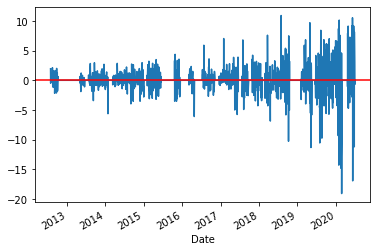

In [50]:
#Add a new column "Profit" using List Comprehension, for any rows in fb, if Shares=1, the profit is calculated as the close price of 
#tomorrow - the close price of today. Otherwise the profit is 0.

#Plot a graph to show the Profit/Loss

stocks['Close1'] = stocks['Adj Close'].shift(-1)
stocks['Profit'] = [stocks.loc[ei, 'Close1'] - stocks.loc[ei, 'Adj Close'] if stocks.loc[ei, 'Shares']==1 else 0 for ei in stocks.index]
stocks['Profit'].plot()
plt.axhline(y=0, color='red')

### 3. Use .cumsum() to display our model's performance if we follow the strategy

In [51]:
#Use .cumsum() to calculate the accumulated wealth over the period

stocks['wealth'] = stocks['Profit'].cumsum()
stocks.tail()

,Adj Close,MA10,MA50,Shares,Close1,Profit,wealth
Date,,,,,,,
2020-06-26,353.630005,355.203998,317.495387,1,361.779999,8.149994,248.331314
2020-06-29,361.779999,357.082999,319.090256,1,364.799988,3.019989,251.351303
2020-06-30,364.799988,358.354999,320.862609,1,364.109985,-0.690002,250.661301
2020-07-01,364.109985,359.606998,322.791899,1,364.109985,0.000000,250.661301
2020-07-02,364.109985,360.844995,324.567006,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Total money you win is 250.6613006591797')

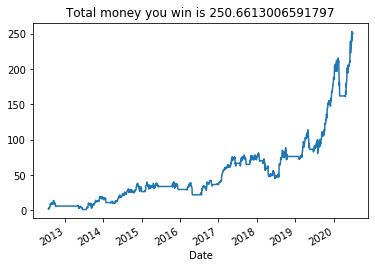

In [52]:
#plot the wealth to show the growth of profit over the period

stocks['wealth'].plot()
plt.title('Total money you win is {}'.format(stocks.loc[stocks.index[-2], 'wealth']))